In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report
import seaborn as sns
import re
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from scipy.sparse import csr_matrix
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score
from textblob import TextBlob
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader
import gensim
from gensim.models import Word2Vec
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

### Загрузка и анализ данных, первичная предобработка

In [10]:
# Папки с данными
part_1_dir = 'part_1'
part_2_dir = 'part_2'

# Списки для хранения текстов и рейтингов
texts = []
ratings = []

def load_reviews_from_folder(folder):
    if os.path.exists(folder):  
        for filename in os.listdir(folder):
            if filename.endswith('.txt'): 
                file_path = os.path.join(folder, filename)  
                # Извлечение рейтинга из имени файла
                try:
                    rating = int(filename.split('_')[-1].split('.')[0])  # Берем часть после '_' и до '.txt'
                except ValueError:
                    print(f"Некорректное имя файла: {filename}")
                    continue
                
                # Чтение содержимого файла
                with open(file_path, 'r', encoding='utf-8') as file:
                    texts.append(file.read())
                    ratings.append(rating)
    else:
        print(f"Папка не найдена: {folder}")

# Загрузка данных из папок
load_reviews_from_folder(part_1_dir + '/pos')
load_reviews_from_folder(part_1_dir + '/neg')

load_reviews_from_folder(part_2_dir + '/pos')
load_reviews_from_folder(part_2_dir + '/neg')

# Создание DataFrame
df = pd.DataFrame({
    'text': texts,
    'target': ratings
})

print(df.head())

                                                text  target
0  I went and saw this movie last night after bei...      10
1  Actor turned director Bill Paxton follows up h...       7
2  As a recreational golfer with some knowledge o...       9
3  I saw this film in a sneak preview, and it is ...       8
4  Bill Paxton has taken the true story of the 19...       8


In [12]:
#df.to_csv('Review_data_new.csv')

In [5]:
df = pd.read_csv('Review_data_new.csv')[['text','target']]

In [24]:
print(f"Пропущенные значения:\n{df.isnull().sum()}")

duplicates = df.duplicated().sum()
print(f"Количество дублирующихся строк: {duplicates}")

Пропущенные значения:
text      0
target    0
dtype: int64
Количество дублирующихся строк: 414


In [26]:
df = df.drop_duplicates()

print(f"Количество строк после удаления дубликатов: {len(df)}")

Количество строк после удаления дубликатов: 49586


In [8]:
df['target'].value_counts()

target
1     10122
10     9731
8      5859
4      5331
3      4961
7      4803
9      4607
2      4586
Name: count, dtype: int64

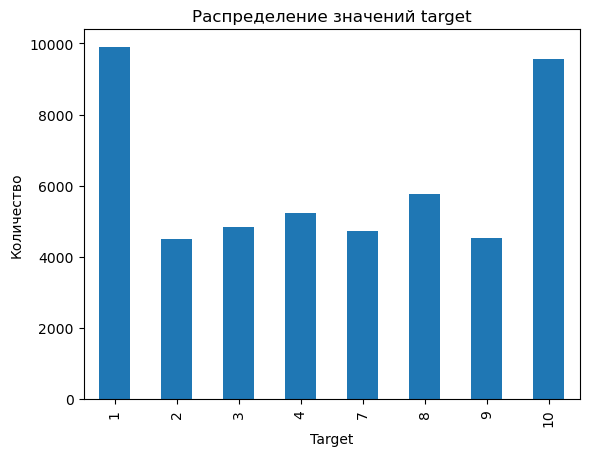

In [108]:
df['target'].value_counts().sort_index().plot(kind='bar', title='Распределение значений target')
plt.xlabel('Target')
plt.ylabel('Количество')
plt.show()

In [30]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

print(df['word_count'].describe())

count    49586.000000
mean       231.349837
std        171.537241
min          4.000000
25%        126.000000
50%        173.000000
75%        281.000000
max       2470.000000
Name: word_count, dtype: float64


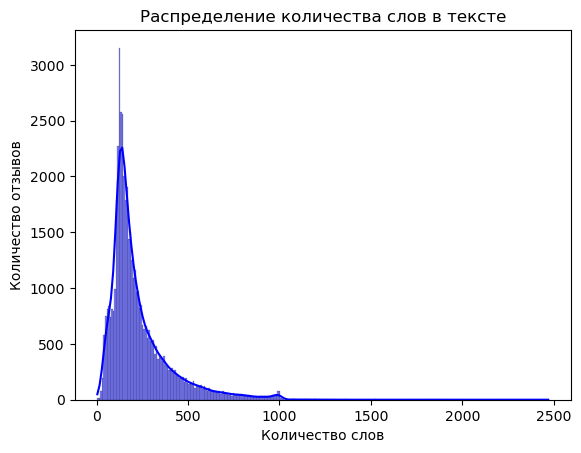

In [31]:
sns.histplot(df['text'].apply(lambda x: len(str(x).split())), kde=True, color='blue')
plt.title('Распределение количества слов в тексте')
plt.xlabel('Количество слов')
plt.ylabel('Количество отзывов')
plt.show()

In [34]:
percentile_99 = df['word_count'].quantile(0.99)
print(f"99%-ный перцентиль: {percentile_99}")

99%-ный перцентиль: 908.0


In [36]:
df = df[df['word_count'] <= percentile_99]

print(f"Количество строк после обрезки: {len(df)}")

Количество строк после обрезки: 49094


### Пробуем разные сентиментальные готовые словари

In [45]:
df_dict = df.copy()

In [47]:
X_train_dict, X_test_dict, y_train_dict, y_test_dict = train_test_split(df_dict['text'], df_dict['target'], test_size=0.2, random_state=42, stratify=df_dict['target'])
print(f"Размер обучающей выборки: {len(X_train_dict)}")
print(f"Размер тестовой выборки: {len(X_test_dict)}")

Размер обучающей выборки: 39275
Размер тестовой выборки: 9819


In [53]:
# Список допустимых рейтингов
valid_ratings = [1, 2, 3, 4, 7, 8, 9, 10]

# Функция для ограничения значений допустимыми рейтингами
def map_to_valid_rating(rating):
    return min(valid_ratings, key=lambda x: abs(x - rating))

# Функция для преобразования compound score в рейтинг
def predict_rating(text):
    scores = analyzer.polarity_scores(text)
    compound = scores['compound']
    
    # Масштабирование compound score (-1...1) в диапазон рейтингов (1–10)
    rating = (compound + 1) * 4.5 + 1 
    
    # Ограничение значений только допустимыми рейтингами
    return map_to_valid_rating(rating)

def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    
    # Масштабирование polarity (-1...1) в диапазон рейтингов (1–10)
    rating = (polarity + 1) * 4.5 + 1  
    
    # Ограничение значений только допустимыми рейтингами
    return map_to_valid_rating(rating)

# Функция для анализа полярности (позитивный/негативный)
def analyze_polarity(true_ratings, predicted_ratings):
    # Разделяем рейтинги на позитивные (7–10) и негативные (1–4)
    def map_to_polarity(rating):
        return "positive" if rating >= 7 else "negative"
    
    true_polarities = [map_to_polarity(rating) for rating in true_ratings]
    predicted_polarities = [map_to_polarity(rating) for rating in predicted_ratings]
    
    # Общая точность по полярности
    polarity_accuracy = accuracy_score(true_polarities, predicted_polarities)
    
    # Точность для каждой полярности
    positive_accuracy = accuracy_score(
        [true for true, pred in zip(true_polarities, predicted_polarities) if true == "positive"],
        [pred for true, pred in zip(true_polarities, predicted_polarities) if true == "positive"]
    )
    negative_accuracy = accuracy_score(
        [true for true, pred in zip(true_polarities, predicted_polarities) if true == "negative"],
        [pred for true, pred in zip(true_polarities, predicted_polarities) if true == "negative"]
    )
    
    print(f"\nТочность по полярности: {polarity_accuracy:.4f}")
    print(f"Точность для позитивных отзывов: {positive_accuracy:.4f}")
    print(f"Точность для негативных отзывов: {negative_accuracy:.4f}")

### SentimentIntensityAnalyzer

In [51]:
# Инициализация анализатора
analyzer = SentimentIntensityAnalyzer()

# Применение функции к данным
y_train_pred = X_train_dict.apply(predict_rating)
y_test_pred = X_test_dict.apply(predict_rating)

# Оценка качества модели
train_mae = mean_absolute_error(y_train_dict, y_train_pred)
test_mae = mean_absolute_error(y_test_dict, y_test_pred)

print("\nРезультаты на обучающей выборке:")
print(f"MAE: {train_mae:.4f}")

print("\nРезультаты на тестовой выборке:")
print(f"MAE: {test_mae:.4f}")

# Анализ полярности
print("\nАнализ полярности train:")
analyze_polarity(y_train_dict, y_train_pred)
print("\nАнализ полярности test:")
analyze_polarity(y_test_dict, y_test_pred)


Результаты на обучающей выборке:
MAE: 2.7972

Результаты на тестовой выборке:
MAE: 2.7894

Анализ полярности train:

Точность по полярности: 0.6959
Точность для позитивных отзывов: 0.8609
Точность для негативных отзывов: 0.5301

Анализ полярности test:

Точность по полярности: 0.6990
Точность для позитивных отзывов: 0.8647
Точность для негативных отзывов: 0.5324


### TextBlob

In [57]:
# Применяем функцию к обучающим и тестовым данным
y_train_pred = [get_sentiment(text) for text in X_train_dict]
y_test_pred = [get_sentiment(text) for text in X_test_dict]

# Оценка качества модели (MAE и Accuracy)
train_mae = mean_absolute_error(y_train_dict, y_train_pred)
test_mae = mean_absolute_error(y_test_dict, y_test_pred)

print("\nРезультаты на обучающей выборке:")
print(f"MAE: {train_mae:.4f}")

print("\nРезультаты на тестовой выборке:")
print(f"MAE: {test_mae:.4f}")

# Анализ полярности
print("\nАнализ полярности:")
analyze_polarity(y_train_dict, y_train_pred)
analyze_polarity(y_test_dict, y_test_pred)


Результаты на обучающей выборке:
MAE: 2.6865

Результаты на тестовой выборке:
MAE: 2.6746

Анализ полярности:

Точность по полярности: 0.6891
Точность для позитивных отзывов: 0.9470
Точность для негативных отзывов: 0.4299

Точность по полярности: 0.6932
Точность для позитивных отзывов: 0.9449
Точность для негативных отзывов: 0.4403


### Подготовка данных и обучение модели машинного обучения

In [59]:
df_machine = df.copy()

In [61]:
# Убираем все неалфавитные символы 
df_machine['text'] = df_machine['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

In [62]:
# Лишние пробелы
df_machine['cleaned_text'] = df_machine['text'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

In [65]:
# Лемматизация

# Загрузка списка стоп-слов
stop_words = set(stopwords.words('english'))

# Инициализация лемматизатора
lemmatizer = WordNetLemmatizer()

# Функция для предобработки текста 
def preprocess_text(text):
    # Токенизация
    words = word_tokenize(text.lower())  # Приведение к нижнему регистру
    # Лемматизация и удаление стоп-слов
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]
    return ' '.join(words)

# Применим функцию к столбцу текста
df_machine['cleaned_text'] = df_machine['text'].apply(preprocess_text)

In [66]:
df_machine['cleaned_text'].head()

0    went saw movie last night coaxed friend mine i...
1    actor turned director bill paxton follows prom...
2    recreational golfer knowledge sport history pl...
3    saw film sneak preview delightful cinematograp...
4    bill paxton taken true story u golf open made ...
Name: cleaned_text, dtype: object

In [67]:
X_train, X_test, y_train, y_test = train_test_split(df_machine['cleaned_text'], df_machine['target'], test_size=0.2, random_state=42, stratify=df_machine['target'])
print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер тестовой выборки: {len(X_test)}")

Размер обучающей выборки: 39275
Размер тестовой выборки: 9819


### TFIDF и Catboost

In [68]:
vectorizer = TfidfVectorizer(min_df=5, max_df=0.9)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Размер матрицы: {X_train_tfidf.shape}")

Размер матрицы: (39275, 32255)


In [76]:
# Векторизация текста с помощью TF-IDF
vectorizer = TfidfVectorizer(min_df=5, max_df=0.9)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Размер матрицы: {X_train_tfidf.shape}")

# Обучение модели CatBoostRegressor
model = CatBoostRegressor(iterations=800, 
                          learning_rate=0.05, 
                          depth=4, 
                          verbose=200)

model.fit(X_train_tfidf, y_train)

# Предсказания на тестовой выборке
y_test_pred_raw = model.predict(X_test_tfidf)

# Ограничение предсказаний допустимыми рейтингами
y_test_pred = [map_to_valid_rating(pred) for pred in y_test_pred_raw]

# Предсказания на обучающей выборке
y_train_pred_raw = model.predict(X_train_tfidf)
y_train_pred = [map_to_valid_rating(pred) for pred in y_train_pred_raw]

# Оценка качества модели (MAE и Accuracy)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)


print("\nРезультаты на обучающей выборке:")
print(f"MAE: {train_mae:.4f}")

print("\nРезультаты на тестовой выборке:")
print(f"MAE: {test_mae:.4f}")

# Анализ полярности
print("\nАнализ полярности:")
analyze_polarity(y_train, y_train_pred)
analyze_polarity(y_test, y_test_pred)

Размер матрицы: (39275, 32255)
0:	learn: 3.4419628	total: 206ms	remaining: 2m 44s
200:	learn: 2.5481927	total: 28.6s	remaining: 1m 25s
400:	learn: 2.3908837	total: 56.7s	remaining: 56.4s
600:	learn: 2.3016078	total: 1m 24s	remaining: 27.9s
799:	learn: 2.2378032	total: 1m 52s	remaining: 0us

Результаты на обучающей выборке:
MAE: 1.6970

Результаты на тестовой выборке:
MAE: 1.7694

Анализ полярности:

Точность по полярности: 0.8610
Точность для позитивных отзывов: 0.9038
Точность для негативных отзывов: 0.8180

Точность по полярности: 0.8495
Точность для позитивных отзывов: 0.8970
Точность для негативных отзывов: 0.8017


### Word2Vec и Catboost

In [116]:
X_train_tokens = [text.split() for text in X_train] 

model_w2v = Word2Vec(sentences=X_train_tokens, vector_size=200, window=10, min_count=5, workers=4)

def vectorize_text(text, model, vector_size=100):
    words = text.split()
    word_vectors = []
    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])
    
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(vector_size) 

X_train_w2v = np.array([vectorize_text(text, model_w2v) for text in X_train])

X_test_w2v = np.array([vectorize_text(text, model_w2v) for text in X_test])

print(X_train_w2v.shape)
print(X_test_w2v.shape)

(39275, 200)
(9819, 200)


In [117]:
# Обучение модели CatBoostRegressor
model = CatBoostRegressor(iterations=800, 
                          learning_rate=0.05, 
                          depth=4, 
                          verbose=200)

model.fit(X_train_w2v, y_train)

# Предсказания на тестовой выборке
y_test_pred_raw = model.predict(X_test_w2v)

# Ограничение предсказаний допустимыми рейтингами
y_test_pred = [map_to_valid_rating(pred) for pred in y_test_pred_raw]

# Предсказания на обучающей выборке
y_train_pred_raw = model.predict(X_train_w2v)
y_train_pred = [map_to_valid_rating(pred) for pred in y_train_pred_raw]

# Оценка качества модели (MAE и Accuracy)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

print("\nРезультаты на обучающей выборке:")
print(f"MAE: {train_mae:.4f}")

print("\nРезультаты на тестовой выборке:")
print(f"MAE: {test_mae:.4f}")

# Анализ полярности
print("\nАнализ полярности:")
analyze_polarity(y_train, y_train_pred)
analyze_polarity(y_test, y_test_pred)

0:	learn: 3.4084094	total: 8.77ms	remaining: 7.01s
200:	learn: 2.2559609	total: 1.47s	remaining: 4.39s
400:	learn: 2.1709896	total: 2.85s	remaining: 2.83s
600:	learn: 2.1162817	total: 4.29s	remaining: 1.42s
799:	learn: 2.0725841	total: 5.69s	remaining: 0us

Результаты на обучающей выборке:
MAE: 1.5117

Результаты на тестовой выборке:
MAE: 1.6062

Анализ полярности:

Точность по полярности: 0.8692
Точность для позитивных отзывов: 0.8824
Точность для негативных отзывов: 0.8560

Точность по полярности: 0.8568
Точность для позитивных отзывов: 0.8651
Точность для негативных отзывов: 0.8485


### Bert

#### Обучение

In [87]:
assert torch.cuda.is_available(), "GPU недоступен!"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")


# Преобразование рейтингов в метки 0-7
rating_to_label = {1: 0, 2: 1, 3: 2, 4: 3, 7: 4, 8: 5, 9: 6, 10: 7}
df['label'] = df['target'].map(rating_to_label).astype(int)

# Инициализация модели
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=8).to(device)

train_data, val_data = train_test_split(df, test_size=0.1, random_state=42)

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0).to(device),
            'attention_mask': encoding['attention_mask'].squeeze(0).to(device),
            'label': torch.tensor(self.labels[idx], dtype=torch.long).to(device)
        }

# Создание датасетов
train_dataset = TextDataset(train_data['text'].tolist(), train_data['label'].tolist(), tokenizer)
val_dataset = TextDataset(val_data['text'].tolist(), val_data['label'].tolist(), tokenizer)

# Конфигурация обучения 
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",  
    save_strategy="epoch",        
    load_best_model_at_end=True,  
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    fp16=True,                    
    metric_for_best_model="eval_loss",  
    greater_is_better=False,       
)

print(f"Память GPU до обучения: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)


Используется устройство: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Память GPU до обучения: 418.75 MB


C:\Users\egor\anaconda\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\egor\AppData\Local\Temp\ipykernel_15268\320214532.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [15]:
trainer.train()

# Сохранение модели
model.save_pretrained("./fine_tuned_bert_ratings_gpu")
tokenizer.save_pretrained("./fine_tuned_bert_ratings_gpu")

Epoch,Training Loss,Validation Loss
1,1.193700,1.177016
2,1.112600,1.161383
3,1.154300,1.213938


('./fine_tuned_bert_ratings_gpu\\tokenizer_config.json',
 './fine_tuned_bert_ratings_gpu\\special_tokens_map.json',
 './fine_tuned_bert_ratings_gpu\\vocab.txt',
 './fine_tuned_bert_ratings_gpu\\added_tokens.json')

#### Проверка на валидационной выборке

In [96]:
# Преобразование рейтингов в метки и обратно
rating_to_label = {1: 0, 2: 1, 3: 2, 4: 3, 7: 4, 8: 5, 9: 6, 10: 7}
label_to_rating = {idx: rating for rating, idx in rating_to_label.items()}

# Загрузка модели и токенизатора
model_path = "./fine_tuned_bert_ratings_gpu"
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=8)
tokenizer = BertTokenizer.from_pretrained(model_path)

# Перемещение модели на GPU
model.to(device)
model.eval()

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0)
        }

val_texts = val_data['text'].tolist()
val_labels = val_data['target'].tolist()

val_dataset = TextDataset(val_texts, tokenizer)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        inputs = {key: batch[key].to(device) for key in batch}
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)

        valid_predictions = [label_to_rating[pred.item()] for pred in predicted_labels]
        all_predictions.extend(valid_predictions)

# Сохранение истинных рейтингов
all_true_labels = val_labels

# Оценка качества модели
mae = mean_absolute_error(all_true_labels, all_predictions)

print(f'\nРезультаты на валидационной выборке:')
print(f'MAE: {mae:.4f}')


Результаты на валидационной выборке:
MAE: 0.5525


In [98]:
print("\nАнализ полярности:")
analyze_polarity(all_true_labels, all_predictions)


Анализ полярности:

Точность по полярности: 0.9811
Точность для позитивных отзывов: 0.9827
Точность для негативных отзывов: 0.9793
